**Developed by:** [Georgii Bocharov](https://github.com/georgebv)

**E-Mail:** bocharovgeorgii@gmail.com

**pyextremes:** https://github.com/georgebv/pyextremes

# Introduction
This notebook provides a basic (yet, likely, the most common in everyday usage) example of how the [pyextremes](https://github.com/georgebv/pyextremes) library can be used to perform the Extreme Value Analysis (EVA). This example covers estimation of extreme water levels, data for which was obtained from the New York City [the Battery](https://tidesandcurrents.noaa.gov/stationhome.html?id=8518750) tidal station. Data for this station was extracted using the [coastlib](https://github.com/georgebv/coastlib) library which provides an interface to the [NOAA CO-OPS API](https://tidesandcurrents.noaa.gov/api/).

# Set up the environment
First, we need to setup the environment. In this tutorial we will cover the most common, top-level interface of the `pyxtremes` library - the `EVA` class. Let's import it:

In [1]:
from pyextremes import EVA, __version__
print('pyextremes', __version__)

pyextremes 0.1.0


`EVA` is a class which provides interface to the most important features of the `pyxtremes` library. It allows to perform all key tasks comprising the Extreme Value Analysis, such as:
- extraction of extreme values using either Block Maxima (`BM`) or Peaks-over-Threshold (`POT`) methods
- fitting a model to the extracted extreme values using either Maximum Likelihood Estimate (`MLE`, built as a wrapper around [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) distributions) or Markov Chain Monte Carlo (MCMC, called `Emcee` as it's built around the [emcee](https://emcee.readthedocs.io/en/stable/) library by Dan Foreman-Mackey)
- inference of extreme values associated with given return periods (exceedance probabilities) using the selected model and graphical visualization of results

For each of the analysis phases listed above the `EVA` class provides a rich assortment of tools for analytics, visualization, and reporting. All of these tools are conveniently wrapped within the `EVA` class interface and require minimum knowledge of the API by the user.

Now, let's import other packages required for this notebook:

In [2]:
import numpy as np
import pandas as pd

# Load the data
First, we need to load the data which will be used in this tutorial. Data provided to the `pyextremes.EVA` class must meet the following criteria:
- it must be a `pandas.Series` object
- its index must be a sequence of date-time objects
- it should be sorted in ascending order along its index
- it should contain no `nan` entries and all values must be numeric

Let's load and pre-process the data:

In [3]:
data = pd.read_csv('../data/battery_wl.csv', index_col=0, parse_dates=True, squeeze=True)
data = (
    data
    .sort_index(ascending=True)
    .astype(float)
    .dropna()
)
data.head()

Date-Time (GMT)
1920-06-01 05:00:00   -0.659
1920-06-01 06:00:00   -0.873
1920-06-01 07:00:00   -1.025
1920-06-01 08:00:00   -0.964
1920-06-01 09:00:00   -0.659
Name: Water Elevation [m NAVD88], dtype: float64

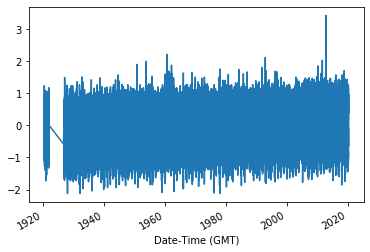

In [4]:
data.plot()

Before proceeding further, let's remove entries before the large gap ending in 1925 and detrend the data by removing a linear trend (mean sea level rise, 2.87mm/yr for this area) around the current tidal epoch (1992): 

In [5]:
data = data.loc[pd.to_datetime('1925'):]
data = data - (data.index.array - pd.to_datetime('1992')) / pd.to_timedelta('1Y') * 2.87e-3
data.head()

Date-Time (GMT)
1926-11-20 05:00:00   -0.411120
1926-11-20 06:00:00   -0.777120
1926-11-20 07:00:00   -1.051120
1926-11-20 08:00:00   -1.051121
1926-11-20 09:00:00   -0.808121
Name: Water Elevation [m NAVD88], dtype: float64

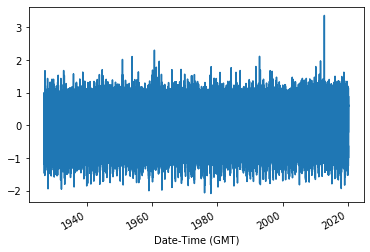

In [6]:
data.plot()

# Initialize the EVA object
After the data has been pre-processed and is ready for extreme value analysis, we can initialize the `EVA` object. The `EVA` class takes only one parameter - `data`. Let's do this:

In [7]:
model = EVA(data=data)
model

                                       Extreme Value Analysis                                       
                                           Original Data                                            
----------------------------------------------------------------------------------------------------
Data label:          Water Elevation [m NAVD88]      Data range:         November 1926 to March 2020
                                           Extreme Values                                           
----------------------------------------------------------------------------------------------------
Extreme values have not been extracted
                                               Model                                                
----------------------------------------------------------------------------------------------------
Model has not been fit to the extremes

As seen above, the text representation of the `EVA` object shows a brief summary of the state of the model. It also suggests sequence in which the analysis should be performed.

# Extract extreme values
Having the `EVA` object initialized, we are ready to perform the first step of the analysis - extreme value extraction. In this tutorial we will use the Block Maxima (`BM`) extraction method with a block size of 1 year. What this means in the framework of the model is that the data is split into one-year blocks and within each of the blocks the highest value is found and added to the `extremes` series. Let's extract the extreme values using this method:

In [8]:
model.get_extremes(method='BM', block_size='1Y', extremes_type='high', errors='raise')
model

                                       Extreme Value Analysis                                       
                                           Original Data                                            
----------------------------------------------------------------------------------------------------
Data label:          Water Elevation [m NAVD88]      Data range:         November 1926 to March 2020
                                           Extreme Values                                           
----------------------------------------------------------------------------------------------------
Number of extreme events:                    94      Extraction method:                           BM
Type of extreme events:                    high      Block size:                   365 days 05:49:12
                                               Model                                                
-------------------------------------------------------------------------------------------

Detailed description of parameters passed to the `get_extremes` method are provided in the docstrings:

In [9]:
help(EVA.get_extremes)

Help on function get_extremes in module pyextremes.eva:

get_extremes(self, method: str, extremes_type: str = 'high', **kwargs) -> None
    Get extreme events from a signal time series using a specified extreme value extraction method.
    Stores extreme values in the self.extremes attribute.
    
    Parameters
    ----------
    method : str
        Extreme value extraction method.
        Supported values: BM or POT.
    extremes_type : str, optional
        high (default) - get extreme high values
        low - get extreme low values
    kwargs
        if method is BM:
            block_size : str or pandas.Timedelta, optional
                Block size (default='1Y').
            errors : str, optional
                raise (default) - raise an exception when encountering a block with no data
                ignore - ignore blocks with no data
                coerce - get extreme values for blocks with no data as mean of all other extreme events
                    in the series w

A great way to visually asses the extracted extreme values is to plot them agains the original time series. This can be done using the `plot_extremes` method. In the case of Block Maxima extraction method, block boundaries are shown.

(<Figure size 768x474.66 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ca879d9f08>)

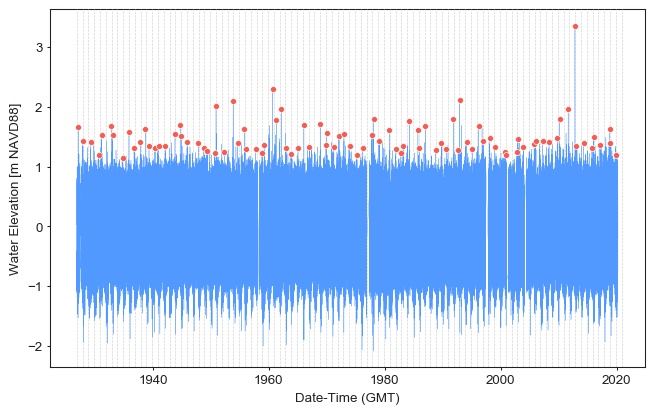

In [10]:
model.plot_extremes()

# Fit a model
The next step of the analysis is fitting a model to the extracted extreme values. Two fitting models are available: `MLE` and `Emcee`. In this tutorial we will use the `MLE` model - it's a simple model which finds a point estimate of distribution parameters and calculates confidence intervals using bootstrapping. The two key parameters required by a model are: `model` - a model name, and `distribution` - distribution name, compliant with [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) distribution names. Let's fit the model for `genextreme` distribution (commonly known as Generalized Extreme Value or GEV distribution):

In [11]:
model.fit_model(
    model='MLE',
    distribution='genextreme'
)
model

                                       Extreme Value Analysis                                       
                                           Original Data                                            
----------------------------------------------------------------------------------------------------
Data label:          Water Elevation [m NAVD88]      Data range:         November 1926 to March 2020
                                           Extreme Values                                           
----------------------------------------------------------------------------------------------------
Number of extreme events:                    94      Extraction method:                           BM
Type of extreme events:                    high      Block size:                   365 days 05:49:12
                                               Model                                                
-------------------------------------------------------------------------------------------

Detailed description of parameters passed to the `fit_model` method are provided in the docstrings:

In [12]:
help(model.fit_model)

Help on method fit_model in module pyextremes.eva:

fit_model(model: str, distribution: str, **kwargs) -> None method of pyextremes.eva.EVA instance
    Fit a model to the extracted extreme values.
    
    Parameters
    ----------
    model : str
        Name of an extreme value distribution fitting model.
        Supported names:
            MLE - Maximum Likelihood Estimate model (based on scipy)
            Emcee - Markov Chain Monte Carlo model based on the emcee package by Daniel Foreman-Mackey
    distribution : str
        Name of scipy.stats distribution.
    kwargs
        Model-specific keyword arguments.
        MLE model:
            MLE model takes no additional arguments.
        Emcee model:
            n_walkers : int, optional
                The number of walkers in the ensemble (default=100).
            n_samples : int, optional
                The number of steps to run (default=1000).
            progress : bool or str, optional
                If True, a progre

A quick way to analyze quality of the model is to use a method called `plot_diagnostic`. This method provides a two-by-two plot showing return values, PDF, Q-Q, and P-P plots. Let's plot it:

(<Figure size 768x768 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1ca87d17f88>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1ca87bff148>))

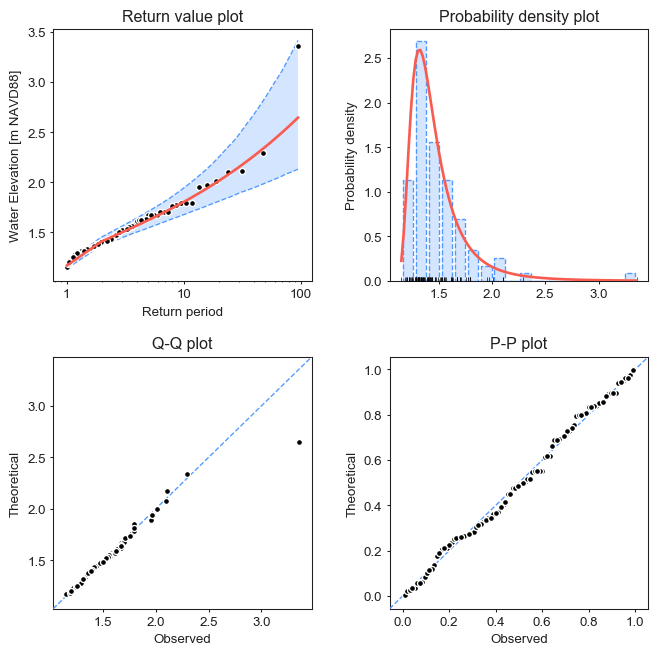

In [13]:
model.plot_diagnostic()

The first time confidence intervals are calculated the model may run slow. However, as results of calculations related to return values and confidence intervals are hashed internally, all subsequent calls with the same parameters should be nearly instantaneous.

# Get output
As the extreme values have been extracted and a model has been fit to the data, we are ready to produce a return value plot and get a summary of projected extreme return values. Let's do this:

(<Figure size 768x474.66 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ca94e053c8>)

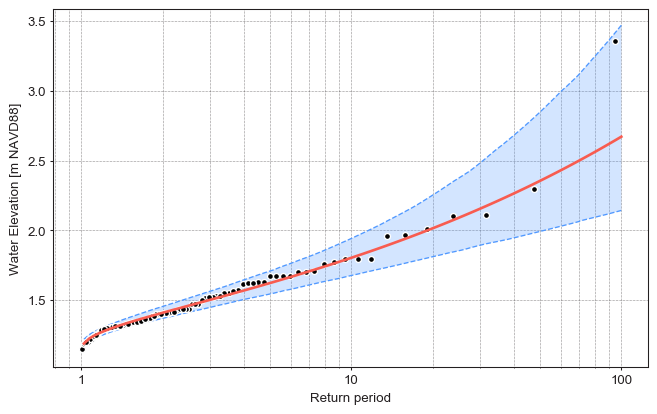

In [14]:
model.plot_return_values(return_period=np.logspace(0.01, 2, 100))

In [15]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000
)
summary

,return value,lower ci,upper ci
return period,,,
1,0.802610,-0.292799,1.026228
2,1.409343,1.369314,1.454389
5,1.622565,1.544065,1.708618
10,1.803499,1.676478,1.941844
25,2.090267,1.853937,2.374607
50,2.354889,1.992353,2.848108
100,2.671313,2.142756,3.469926
